<a href="https://colab.research.google.com/github/ezorigo/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [1]:
### YOUR CODE STARTS HERE
# Load data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-08-20 06:25:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.4’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-08-20 06:25:21 (286 KB/s) - ‘house-votes-84.data.4’ saved [18171/18171]



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names

--2019-08-20 06:25:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6868 (6.7K) [application/x-httpd-php]
Saving to: ‘house-votes-84.names.4’

house-votes-84.name 100%[===================>]   6.71K  --.-KB/s    in 0s      

2019-08-20 06:25:22 (124 MB/s) - ‘house-votes-84.names.4’ saved [6868/6868]



In [3]:
!head house-votes-84.data

republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
democrat,n,y,n,y,y,y,n,n,n,n,n,n,?,y,y,y
republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,?,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,?,?


In [4]:
!tail house-votes-84.data

democrat,n,n,y,n,n,n,y,y,n,y,y,n,n,n,y,?
democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y
republican,n,n,n,y,y,y,y,y,n,y,n,y,y,y,n,y
democrat,?,?,?,n,n,n,y,y,y,y,n,n,y,n,y,y
democrat,y,n,y,n,?,n,y,y,y,y,n,y,n,?,y,y
republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,?,n


In [5]:
!cat house-votes-84.names

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')

df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [7]:
df = df.replace({'?':np.NaN, 'n':0, 'y':1})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [8]:
df.isna().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [49]:
rep = df[df['party'] == 'republican']
print(rep.shape)
rep.head()

(168, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [50]:
dem = df[df['party'] == 'democrat']
print(dem.shape)
dem.head()

(267, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [12]:
df.party.value_counts()

democrat      267
republican    168
Name: party, dtype: int64

In [0]:
from scipy.stats import ttest_ind

In [101]:
# Null hypothestis: There is more support for this bill among democrats in the house.
# Alternative: There is more support for this bill among republicans in the house.
ttest_ind(dem['education'], rep['education'], nan_policy='omit')

# Conclusion: Due to a t-statistic of -20.501 and a p-value of 0, we reject the null 
# hypothesis that there is more support for this bill among democrats, and suggest
# the alternative that there is more support for this bill among republicans. I also
# used sns.countplot to confirm my findings.

# TRIED TO USE SNS.DISTPLOT BUT IT WAS BEING REALLY FUNKY WITH SOME OF THE GRAPHS.

Ttest_indResult(statistic=-20.500685724563073, pvalue=1.8834203990450192e-64)

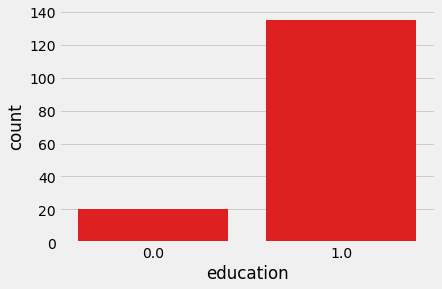

In [95]:
sns.countplot(rep['education'].dropna(), color='r');

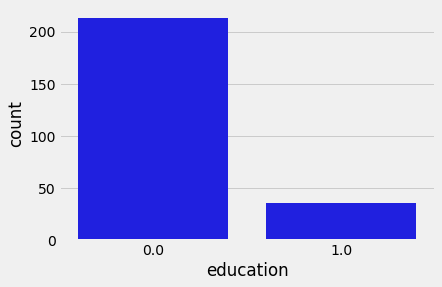

In [96]:
sns.countplot(dem['education'].dropna(), color='b');

In [25]:
# Null hypothestis: There is more support for this bill among republicans in the house.
# Alternative: There is more support for this bill among democrats in the house.
ttest_ind(rep['right-to-sue'], dem['right-to-sue'], nan_policy='omit')

# Conclusion: due to t-statistic of 13.511 and a p-value of 0 we confirm that the
# republican party does have more support for this bill. we use the countplot 
# to makre sue of our answers that republicans supported this bill more than the
# democrats. I suggest that the null hypothesis is true.

Ttest_indResult(statistic=13.51064251060933, pvalue=1.2278581709672758e-34)

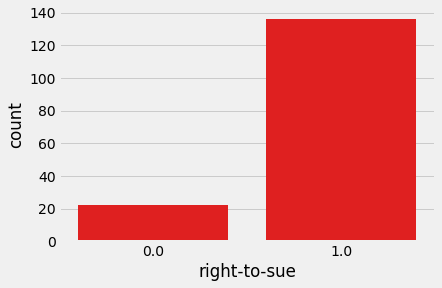

In [82]:
sns.countplot(rep['right-to-sue'].dropna(), color='r');

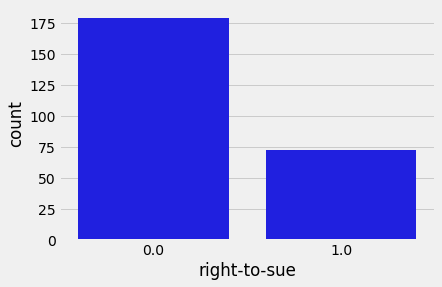

In [81]:
sns.countplot(dem['right-to-sue'].dropna(), color='b');

In [23]:
# Null hypothestis: There is more support for this bill among republicans in the house.
# Alternative: There is more support for this bill among democrats in the house.
ttest_ind(rep['immigration'], dem['immigration'], nan_policy='omit')

# Conclusion: Due to a t-statistic of 1.736 and a p-value of 0.083, we can see that
# there is a slight difference and a 8.3% probability of that being due to random chance.
# I suggect that the null hypothese is true but it is a small difference.

Ttest_indResult(statistic=1.7359117329695164, pvalue=0.08330248490425066)

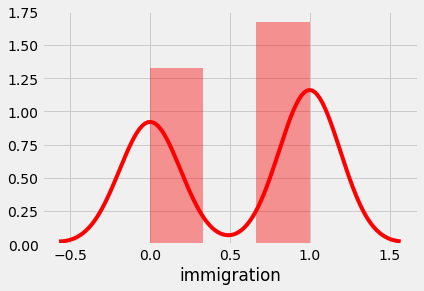

In [53]:
sns.distplot(rep['immigration'].dropna(), color='r');

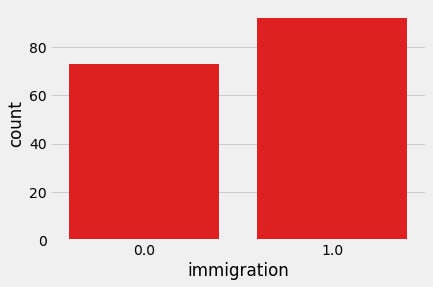

In [91]:
sns.countplot(rep['immigration'].dropna(), color='r');

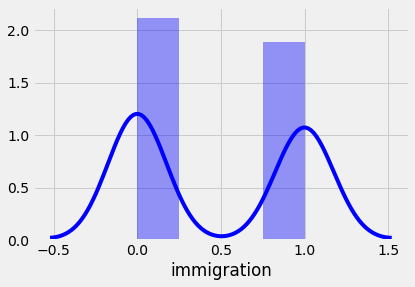

In [54]:
sns.distplot(dem['immigration'].dropna(), color='b');

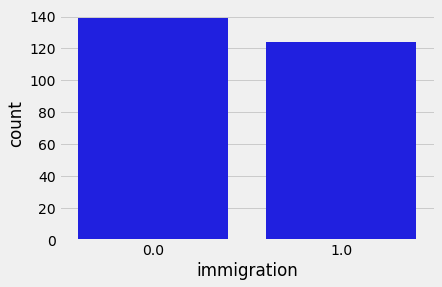

In [92]:
sns.countplot(dem['immigration'].dropna(), color='b');